In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

from world import World
from utils import plotarrows, getpolicy, getvalue

plt.rcParams['figure.facecolor']='white'

In [2]:
which_world = 2 #Change later. Valid options: [1-4]

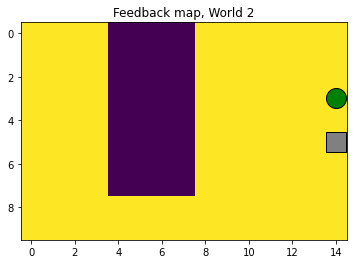

In [3]:
# Initialization
# Initialize the world, Q-table, and hyperparameters

# Init world and draw
world = World(which_world)
world.draw()

# Init Q-table
x_size = world.x_size # 15
y_size = world.y_size # 10
n_actions = 4 # up, down, left ,right

# Initialize q_table as small random negative numbers
q_table = (-1/10)*np.ones((y_size, x_size, n_actions)) 
with np.nditer(q_table, op_flags=['readwrite']) as it:
    for x in it:
        x[...] -= np.random.random() / 10
        
# Set actions in terminal node to 100 according to hints in compendium.
q_table[world.term[0], world.term[1]] = 100

    # Init hyperparams
if which_world == 1:
    lr = 0.9 # Since world is static we can have a large learning rate
    discount = 0.95 # Recommended start at 0.9: Lower -> short term, higher -> long term. Here we want longterm
    epsilon = 0.9 # Higher epsilon focus on exploration, lower on exploitation
    n_episodes = 500 #1000 # Number of iterations
    epsilonDecay = 0.999 # Low decay of epsilon: Dont think we need for this problem
elif which_world == 2:
    # Since this world changes to sometimes we make the algorithm retain more information from previous states
    lr = 0.25     # Therefore we decrease the learning rate to keep more information from previous q-values.
    discount = 0.9 # Recommended start at 0.9
    epsilon = 0.5 # Higher epsilon focus on exploration, lower on exploitation
    n_episodes = 1000 #1000 # Number of iterations
    epsilonDecay = 0.995 # Here we decay the learning rate continiously
elif which_world == 3:
    lr = 0.95
    discount = 0.9 # Here we decrease the discount so that the algorithm focuses more on short term goals instead of long term -> this way we perhaps avoid the negative area.
    epsilon = 0.9 # Higher epsilon focus on exploration, lower on exploitation
    n_episodes = 100 #1000 # Number of iterations
    epsilonDecay = 0.99
elif which_world == 4:
    # Havnt experimented too much with hyperparams but the world has a 0.3 probability of random action so we want the agent to take the longer (safer) path
    lr = 0.1
    discount = 0.9 # Here we decrease the discount so that the algorithm focuses more on short term goals instead of long term -> this way we perhaps avoid the negative area.
    epsilon = 0.9 # Higher epsilon focus on exploration, lower on exploitation
    n_episodes = 5000 #1000 # Number of iterations
    epsilonDecay = 0.99
    

In [4]:
#print(f"Starting position: {world.pos}")
print(f"Feed map matrix: {world.feed}")
#print(f"Goal position. {world.term}")
#print(f"Max reward: {np.max(world.feed)}")
#print(f"Q-TABLE: {q_table}")
#q_table[world.pos[0], world.pos[1]]

Feed map matrix: [[ -0.1  -0.1  -0.1  -0.1 -11.  -11.  -11.  -11.   -0.1  -0.1  -0.1  -0.1
   -0.1  -0.1  -0.1]
 [ -0.1  -0.1  -0.1  -0.1 -11.  -11.  -11.  -11.   -0.1  -0.1  -0.1  -0.1
   -0.1  -0.1  -0.1]
 [ -0.1  -0.1  -0.1  -0.1 -11.  -11.  -11.  -11.   -0.1  -0.1  -0.1  -0.1
   -0.1  -0.1  -0.1]
 [ -0.1  -0.1  -0.1  -0.1 -11.  -11.  -11.  -11.   -0.1  -0.1  -0.1  -0.1
   -0.1  -0.1  -0.1]
 [ -0.1  -0.1  -0.1  -0.1 -11.  -11.  -11.  -11.   -0.1  -0.1  -0.1  -0.1
   -0.1  -0.1  -0.1]
 [ -0.1  -0.1  -0.1  -0.1 -11.  -11.  -11.  -11.   -0.1  -0.1  -0.1  -0.1
   -0.1  -0.1  -0.1]
 [ -0.1  -0.1  -0.1  -0.1 -11.  -11.  -11.  -11.   -0.1  -0.1  -0.1  -0.1
   -0.1  -0.1  -0.1]
 [ -0.1  -0.1  -0.1  -0.1 -11.  -11.  -11.  -11.   -0.1  -0.1  -0.1  -0.1
   -0.1  -0.1  -0.1]
 [ -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1
   -0.1  -0.1  -0.1]
 [ -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1
   -0.1  -0.1  -0.1]]


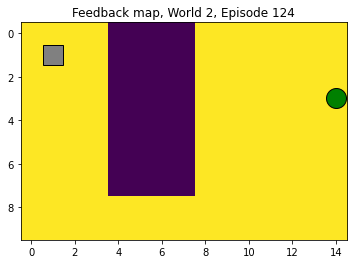

In [ ]:
def epsilon_decay(epsilon, decay_param):
    """Function to control decay of the epsilon"""
    
    epsilon = epsilon * decay_param
    
    if epsilon < 0.1:
        return 0.1
    else:
        return epsilon

####### The training loop #######
for episode in range(n_episodes):
    
    if episode != 0: # If not first episode -> init a new world
        world = World(which_world)
        
    # Find current position at start of new episode
    current_location = world.pos
    
    while world.pos != world.term: # While not in a terminal state do
        
        previous_location = world.pos
        # Decide which action to take by greedy exploitation
        if np.random.random() < epsilon:
            action = np.random.randint(4) + 1 # Generate integer between 1 and 4
        else:
            action = np.argmax(q_table[world.pos[0],world.pos[1]]) + 1
        # Take the action
        action_data = world.action(action)
        # Draw the world
        world.draw(episode = episode, sleepTime = 0)
        # Get new location
        current_location = world.pos
        ### Get the reward for moving to the new location
        
        if action_data[0] == 0:
            reward = -np.inf # If invalid action then negative reward
        else:
            reward = action_data[1] # If action is valid then actual reward
            
        if world.pos == world.term:
            reward = 100 # Big reward if hit terminal
        
       # Update Q-table
        q_table[previous_location[0], previous_location[1], action-1] = (1-lr)*q_table[previous_location[0], previous_location[1], action-1] + lr*(reward + discount*getvalue(q_table[current_location[0], current_location[1]]))
    
    if which_world == 1 or which_world == 2:
        if episode > n_episodes * 0.75:
            epsilon = 1/3
    else:
        epsilon = epsilon_decay(epsilon, epsilonDecay)
        

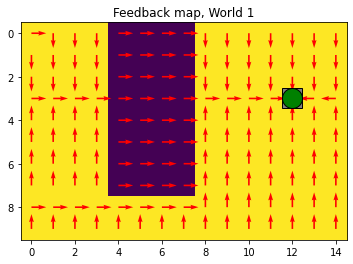

In [7]:
# Test loop
# Test the agent (subjectively) by letting it use the optimal policy to traverse the gridworld.
# Do not update the Q-table when testing.
# Also, you should not explore when testing, i.e. epsilon=0; always pick the optimal action.

#epsilon = 0

# Initialize a test world
world = World(which_world)
# Retrieve the optimal policy
pol = getpolicy(q_table)

##### Test loop #####
while world.pos != world.term: # While not in a terminal state do
    current_location = world.pos # Get current position position
    action = np.argmax(q_table[world.pos[0],world.pos[1]]) + 1
    # Take the action
    action_data = world.action(action)
    world.draw(policy = pol)    

In [ ]:
def plotVfun(Q):
    V = np.max(Q, axis = 2)
    x = np.arange(0, V.shape[1], 1)
    y = np.arange(0, V.shape[0], 1)
    x, y = np.meshgrid(x,y)
    z = V
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    ax.plot_surface(x, y, z,cmap = 'viridis', edgecolor='none')
    ax.set_title('V-function: World 2')
    plt.show()

plotVfun(q_table)
## NOT SURE IF THIS IS WHAT THEY WANT


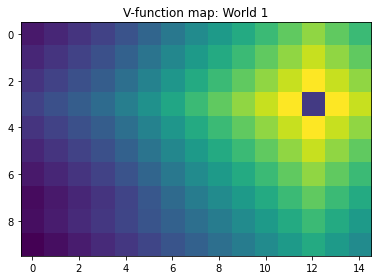

In [8]:
def plotVfun2(Q, World_num):
    V = np.max(Q, axis = 2)
    fig, ax = plt.subplots()
    im = ax.imshow(V)
    ax.set_title(f"V-function map: World {World_num}")
    fig.tight_layout()
    plt.show()
    
plotVfun2(q_table, 1) 